In [3]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from dotenv import load_dotenv

In [4]:
TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "churn_kruglikovAlex" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "../assets"

In [5]:
#os.mkdir(ASSETS_DIR) # или 
os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid")

In [6]:
# подгружаем .env
load_dotenv()

# загрузка данных для обучения модели
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

In [77]:
connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

In [8]:
df.head(5)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,28173,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,0
1,28174,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
2,28175,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
3,28176,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,0
4,28177,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


In [9]:
df.tail()

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
7038,35211,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.50,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,0
7039,35212,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.90,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,0
7040,35213,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,None,0
7041,35214,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.60,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes,1
7042,35215,3186-AJIEK,2014-08-01,NaT,Two year,Yes,Bank transfer (automatic),105.65,6844.50,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Male,0,No,No,No,0


In [10]:
#from sklearn.datasets import make_classification

#data, target = make_classification(n_samples=100, n_features=5, random_state=42)

#columns = [f"feature_{i}" for i in range(data.shape[1])]
#df = pd.DataFrame(data, columns=columns)
#df['target'] = target

print(df.describe())

                 id                     begin_date   
count   7043.000000                           7043  \
mean   31694.000000  2017-04-30 13:01:50.918642944   
min    28173.000000            2013-10-01 00:00:00   
25%    29933.500000            2015-06-01 00:00:00   
50%    31694.000000            2017-09-01 00:00:00   
75%    33454.500000            2019-04-01 00:00:00   
max    35215.000000            2020-02-01 00:00:00   
std     2033.283305                            NaN   

                            end_date  monthly_charges  total_charges   
count                           1869      7043.000000    7032.000000  \
mean   2019-11-15 21:31:18.009630976        64.761692    2283.300441   
min              2019-10-01 00:00:00        18.250000      18.800000   
25%              2019-11-01 00:00:00        35.500000     401.450000   
50%              2019-11-01 00:00:00        70.350000    1397.475000   
75%              2019-12-01 00:00:00        89.850000    3794.737500   
max      

In [11]:
print(df.isnull().sum().sort_values(ascending=False))

end_date             5174
tech_support         1526
online_security      1526
online_backup        1526
device_protection    1526
internet_service     1526
streaming_movies     1526
streaming_tv         1526
multiple_lines        682
total_charges          11
id                      0
type                    0
begin_date              0
customer_id             0
paperless_billing       0
payment_method          0
monthly_charges         0
gender                  0
senior_citizen          0
partner                 0
dependents              0
target                  0
dtype: int64


In [12]:
df.dtypes

id                            int64
customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
gender                       object
senior_citizen                int64
partner                      object
dependents                   object
multiple_lines               object
target                        int64
dtype: object

In [13]:
x = "type"
y = "monthly_charges"
agg_df = pd.DataFrame(df.groupby(x).agg({y: 'sum'})).reset_index() 

In [14]:
agg_df

,type,monthly_charges
0,Month-to-month,257294.15
1,One year,95816.60
2,Two year,103005.85


In [15]:
x = "type"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({y: stat})).reset_index() # ваш код тут #

In [16]:
agg_df, stat[0]

(             type customer_id
                         count
 0  Month-to-month        3875
 1        One year        1473
 2        Two year        1695,
 'count')

/tmp/ipykernel_1680/497188933.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);


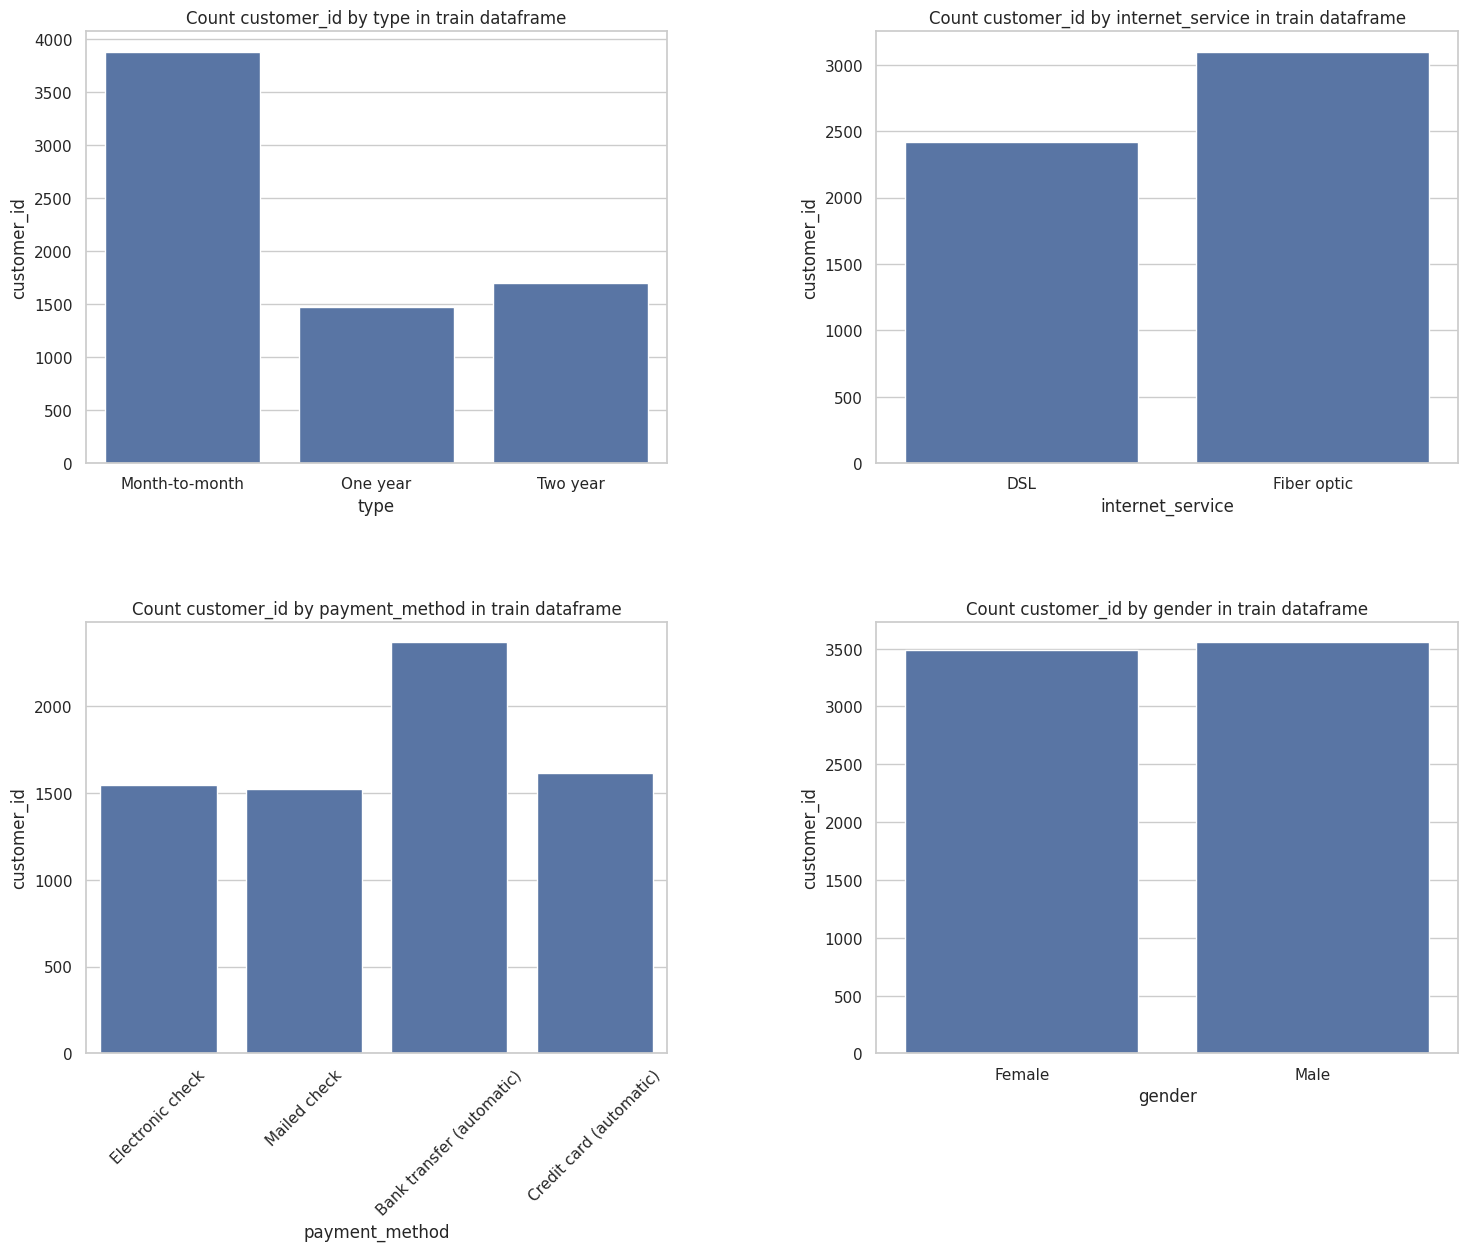

In [17]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)

x = "type"
y = "customer_id"
stat = ["count"]
agg_df = pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index() # ваш код тут #
sns.barplot(
    data=agg_df,
    x="type",
    y="customer_id",
    ax=axs[0, 0]
)
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
y = "customer_id"
# ваш код тут #
agg_df = pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index() # ваш код тут #
sns.barplot(# ваш код тут #
    data=agg_df,
    x=x,
    y=y,
    ax=axs[1, 0]
)
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45);

x = "internet_service"
y = "customer_id"
stat = ["count"]
# ваш код тут #
agg_df = pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index() # ваш код тут #
sns.barplot(# ваш код тут #
    data=agg_df,
    x=x,
    y=y,
    ax=axs[0, 1]
)
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')

x = "gender"
y = "customer_id"
stat = ["count"]
# ваш код тут #
agg_df = pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index() # ваш код тут #
sns.barplot(# ваш код тут #
    data=agg_df,
    x=x,
    y=y,
    ax=axs[1, 1]
)
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1')) 

In [18]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = pd.DataFrame(df.groupby(by=binary_columns).agg({x: 'count'})).reset_index()

In [19]:
stat = stat.sort_values(by="customer_id", ascending=False)

In [20]:
stat.head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,No,No,No,No,No,No,0,No,No,371
106,No,Yes,No,No,No,No,0,No,No,105
414,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,Yes,103
4,No,No,No,No,No,No,1,No,No,101
8,No,No,No,No,No,Yes,0,No,No,90
15,No,No,No,No,Yes,No,0,No,No,86
214,Yes,No,No,No,No,No,0,No,No,83
22,No,No,No,No,Yes,Yes,0,No,No,82
413,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,No,75
3,No,No,No,No,No,No,0,Yes,Yes,68


In [21]:
# или так 
stat = ['count']
test = df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False)
test.head(10)

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,No,No,No,No,No,No,0,No,No,371
106,No,Yes,No,No,No,No,0,No,No,105
414,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,Yes,103
4,No,No,No,No,No,No,1,No,No,101
8,No,No,No,No,No,Yes,0,No,No,90
15,No,No,No,No,Yes,No,0,No,No,86
214,Yes,No,No,No,No,No,0,No,No,83
22,No,No,No,No,Yes,Yes,0,No,No,82
413,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,No,75
3,No,No,No,No,No,No,0,Yes,Yes,68


In [22]:
df[binary_columns].dtypes

online_security      object
online_backup        object
device_protection    object
tech_support         object
streaming_tv         object
streaming_movies     object
senior_citizen        int64
partner              object
dependents           object
dtype: object

In [23]:
mapping = {'Yes': '1', 'No': '0', 0: '0', 1: '1'}
heat_df = df[binary_columns].apply(lambda x: x.map(mapping), axis=0)

In [24]:
heat_df

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents
0,0,1,0,0,0,0,0,1,0
1,1,0,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0
3,1,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,1,1,0,1,1
7039,0,1,1,0,1,1,0,1,1
7040,1,0,0,0,0,0,0,1,1
7041,0,0,0,0,0,0,1,1,0


In [25]:
heat_df = heat_df.apply(pd.Series.value_counts).T
#sns. # ваш код здесь

In [26]:
heat_df

,0,1
online_security,3498,2019
online_backup,3088,2429
device_protection,3095,2422
tech_support,3473,2044
streaming_tv,2810,2707
streaming_movies,2785,2732
senior_citizen,5901,1142
partner,3641,3402
dependents,4933,2110


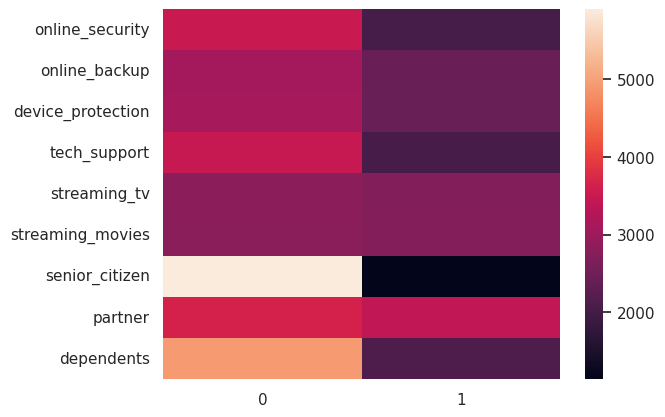

In [27]:
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap')) 

In [28]:
# Постройте два графика для monthly_charges и total_charges, 
# а затем посчитайте средние значение, медиану и моду для 
# каждого begin_date на них. Получившийся график сохраните с названием charges_by_date.

In [29]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

In [30]:
df.head(5)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,28173,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,None,0
1,28174,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
2,28175,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
3,28176,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,None,0
4,28177,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


In [31]:
# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

In [32]:
# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

In [33]:
stats

['mean', 'median', <function __main__.<lambda>(x)>]

In [34]:
# группировка данных по дате начала и агрегация статистик для 
# ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg  = pd.DataFrame(df.groupby(x).agg({charges_columns[0]: stats})).reset_index()

In [35]:
charges_monthly_agg

begin_date monthly_charges                    
                         mean   median <lambda_0>
0  2013-10-01      104.800000  104.150      92.45
1  2013-11-01      108.325000  108.325     108.05
2  2013-12-01       91.066667   93.700      65.30
3  2014-01-01       95.864286  104.050      54.20
4  2014-02-01       80.934153   89.475      24.75
..        ...             ...      ...        ...
71 2019-09-01       59.490928   69.350      20.20
72 2019-10-01       56.259705   58.500      19.95
73 2019-11-01       54.602110   55.800      20.20
74 2019-12-01       52.312955   54.050      19.90
75 2020-01-01       37.909013   25.400      19.75

[76 rows x 4 columns]

In [36]:
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()

In [37]:
charges_monthly_agg

,,mean,median,<lambda_0>
0,2013-10-01,104.800000,104.150,92.45
1,2013-11-01,108.325000,108.325,108.05
2,2013-12-01,91.066667,93.700,65.30
3,2014-01-01,95.864286,104.050,54.20
4,2014-02-01,80.934153,89.475,24.75
...,...,...,...,...
71,2019-09-01,59.490928,69.350,20.20
72,2019-10-01,56.259705,58.500,19.95
73,2019-11-01,54.602110,55.800,20.20
74,2019-12-01,52.312955,54.050,19.90


In [38]:
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

In [39]:
charges_monthly_agg

,begin_date,monthly_mean,monthly_median,monthly_mode
0,2013-10-01,104.800000,104.150,92.45
1,2013-11-01,108.325000,108.325,108.05
2,2013-12-01,91.066667,93.700,65.30
3,2014-01-01,95.864286,104.050,54.20
4,2014-02-01,80.934153,89.475,24.75
...,...,...,...,...
71,2019-09-01,59.490928,69.350,20.20
72,2019-10-01,56.259705,58.500,19.95
73,2019-11-01,54.602110,55.800,20.20
74,2019-12-01,52.312955,54.050,19.90


In [40]:
# аналогично для общих платежей
charges_total_agg = pd.DataFrame(df.groupby(x).agg({charges_columns[1]: stats})).reset_index()# ваш код здесь #
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

In [41]:
charges_total_agg

,begin_date,total_mean,total_median,total_mode
0,2013-10-01,7605.000000,7689.950,6440.25
1,2013-11-01,7611.525000,7611.525,7532.15
2,2013-12-01,6356.333333,6585.350,4759.75
3,2014-01-01,6841.378571,7372.650,3937.45
4,2014-02-01,5820.757923,6433.750,1304.80
...,...,...,...,...
71,2019-09-01,164.163713,122.000,20.20
72,2019-10-01,129.516878,91.100,20.10
73,2019-11-01,108.469409,79.550,19.30
74,2019-12-01,77.464318,70.025,19.90


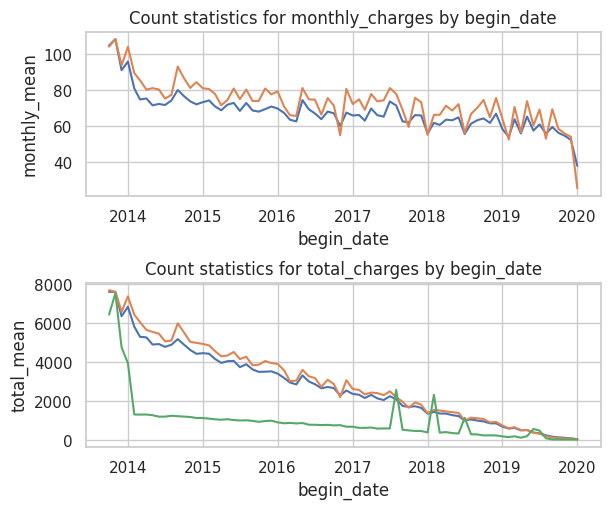

In [42]:
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(
    data=charges_monthly_agg,
    x=x,
    y="monthly_mean",
    ax=axs[0]
)
sns.lineplot(
    data=charges_monthly_agg,
    x=x,
    y="monthly_median",
    ax=axs[0]
)
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(
    data=charges_total_agg,
    x=x,
    y="total_mean", #"total_median", "total_mode"],
    ax=axs[1]
)
sns.lineplot(
    data=charges_total_agg,
    x=x,
    y="total_median",
    ax=axs[1]
)
sns.lineplot(
    data=charges_total_agg,
    x=x,
    y="total_mode",
    ax=axs[1]
)
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date')) 

In [43]:
# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index() # ваш код здесь #
charges_monthly_agg 

begin_date monthly_charges                    
                         mean   median <lambda_0>
0  2013-10-01      104.800000  104.150      92.45
1  2013-11-01      108.325000  108.325     108.05
2  2013-12-01       91.066667   93.700      65.30
3  2014-01-01       95.864286  104.050      54.20
4  2014-02-01       80.934153   89.475      24.75
..        ...             ...      ...        ...
71 2019-09-01       59.490928   69.350      20.20
72 2019-10-01       56.259705   58.500      19.95
73 2019-11-01       54.602110   55.800      20.20
74 2019-12-01       52.312955   54.050      19.90
75 2020-01-01       37.909013   25.400      19.75

[76 rows x 4 columns]

In [44]:
# Задание 5
# Постройте график распределения количества 0 и 1 в 
# вашем датасете. Сохраните график с именем target_count.

In [45]:
# установка названия колонки для агрегации
x = "target"

In [ ]:
# подсчёт количества каждого уникального значения в колонке и сброс индекса для последующей визуализации
target_agg = df[x].value_counts().reset_index()# ваш код здесь #

In [57]:
target_agg

,target,count
0,0,5163
1,1,1869


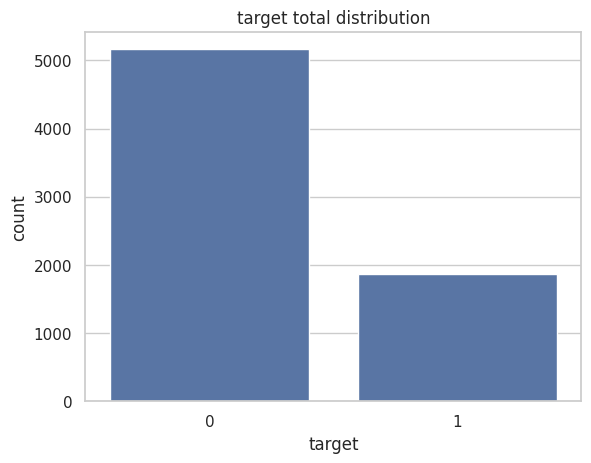

In [62]:
# создание столбчатой диаграммы для визуализации распределения целевой переменной
# ваш код здесь #
sns.barplot(data=target_agg, x=x, y="count")

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count')) 

In [63]:
# Задание 6
# Постройте четыре графика, отражающих следующие зависимости целевой переменной от признаков:
# количество 1 в целевой переменной в зависимости от даты,
# количества 1 и 0 в целевой переменной в зависимости от даты,
# конверсия (количество1, поделённое на общий размер датасета) в зависимости от даты,
# конверсия в зависимости от пола.
# График поможет лучше понять природу ваших данных, чтобы учитывать её при обучении модели. 
# Получившуюся картинку сохраните с именем target_by_date.

In [65]:
# установка переменных для анализа
x = "begin_date"
target = "target"

# определение статистики для агрегации
stat = ["count"]

In [100]:
# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x,target]].groupby([x]).agg(stat).reset_index()# ваш код здесь #

In [101]:
target_agg_by_date

,begin_date,target
,,count
0,2013-10-01,3
1,2013-11-01,2
2,2013-12-01,3
3,2014-01-01,7
4,2014-02-01,366
...,...,...
72,2019-10-01,237
73,2019-11-01,237
74,2019-12-01,220


In [129]:
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

In [130]:
target_agg_by_date

,begin_date,target_count
0,2013-10-01,3
1,2013-11-01,2
2,2013-12-01,3
3,2014-01-01,7
4,2014-02-01,366
...,...,...
72,2019-10-01,237
73,2019-11-01,237
74,2019-12-01,220
75,2020-01-01,233


In [106]:
# подсчёт количества клиентов для каждого значения цели по датам
#target_agg = df[[x] + [target,'customer_id']].groupby(x)['customer_id'].value_counts()
target_agg = df[[x, target, 'customer_id']].groupby([x, target]).count().reset_index()

In [107]:
target_agg

,begin_date,target,customer_id
0,2013-10-01,1,3
1,2013-11-01,1,2
2,2013-12-01,1,3
3,2014-01-01,1,7
4,2014-02-01,0,356
...,...,...,...
143,2019-11-01,1,131
144,2019-12-01,0,115
145,2019-12-01,1,105
146,2020-01-01,0,233


In [108]:
# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()

In [109]:
conversion_agg

,begin_date,sum,count
0,2013-10-01,3,3
1,2013-11-01,2,2
2,2013-12-01,3,3
3,2014-01-01,7,7
4,2014-02-01,10,366
...,...,...,...
72,2019-10-01,144,237
73,2019-11-01,131,237
74,2019-12-01,105,220
75,2020-01-01,0,233


In [ ]:
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

In [111]:
conversion_agg

,begin_date,sum,count,conv
0,2013-10-01,3,3,1.00
1,2013-11-01,2,2,1.00
2,2013-12-01,3,3,1.00
3,2014-01-01,7,7,1.00
4,2014-02-01,10,366,0.03
...,...,...,...,...
72,2019-10-01,144,237,0.61
73,2019-11-01,131,237,0.55
74,2019-12-01,105,220,0.48
75,2020-01-01,0,233,0.00


In [124]:
# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x, target, "gender"]].groupby([x, "gender"])[target].agg(['sum', 'count']).reset_index()# ваш код здесь #
#conversion_agg_gender["conv"] = df[[x] + [target]].groupby([x,target]).value_counts().reset_index() # ваш код здесь #


In [125]:
conversion_agg_gender

,begin_date,gender,sum,count
0,2013-10-01,Female,1,1
1,2013-10-01,Male,2,2
2,2013-11-01,Male,2,2
3,2013-12-01,Female,3,3
4,2014-01-01,Female,3,3
...,...,...,...,...
147,2019-12-01,Male,50,103
148,2020-01-01,Female,0,98
149,2020-01-01,Male,0,135
150,2020-02-01,Female,0,5


In [126]:
conversion_agg_gender["conv"] = (conversion_agg_gender['sum'] / conversion_agg_gender['count']).round(2)

In [127]:
conversion_agg_gender

,begin_date,gender,sum,count,conv
0,2013-10-01,Female,1,1,1.00
1,2013-10-01,Male,2,2,1.00
2,2013-11-01,Male,2,2,1.00
3,2013-12-01,Female,3,3,1.00
4,2014-01-01,Female,3,3,1.00
...,...,...,...,...,...
147,2019-12-01,Male,50,103,0.49
148,2020-01-01,Female,0,98,0.00
149,2020-01-01,Male,0,135,0.00
150,2020-02-01,Female,0,5,0.00


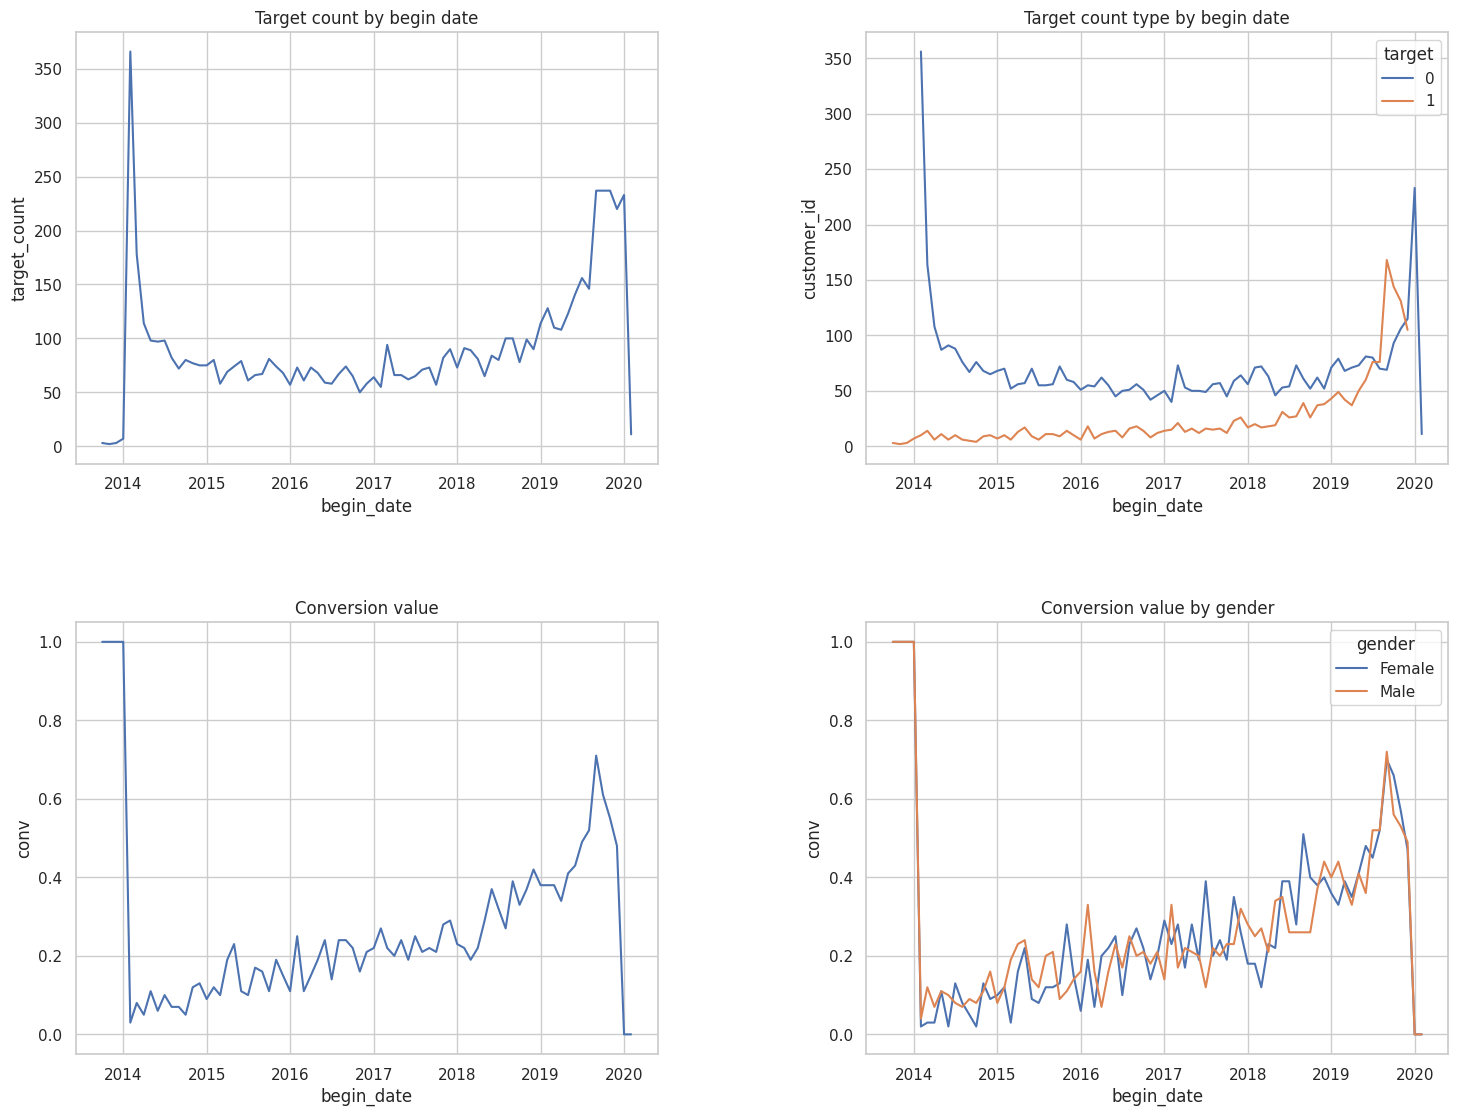

In [131]:
# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y='conv', hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date')) 

In [ ]:
# Задание 7
# Постройте графики распределения monthly_charges и total_charges 
# для каждого события. График отобразите с оценкой плотности, а затем 
# сохраните с названием chargest_by_target_dist.

In [132]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

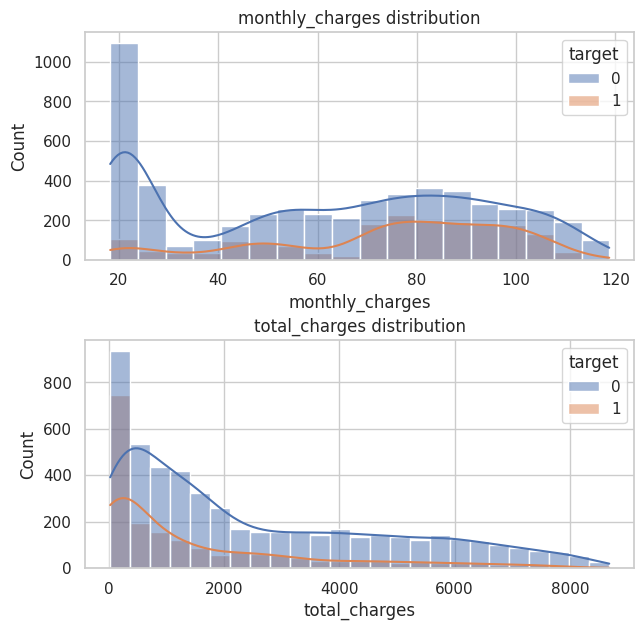

In [138]:
# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменной
sns.histplot(
    data=df, # датафрейм с данными
    x=charges[0], # первый вид платежей для визуализации
    hue=target, # разделение данных по целевой переменной
    kde=True, # включение оценки плотности распределения (Kernel Density Estimate)
    ax=axs[0] # указание, на каком подграфике отобразить гистограмму
    )

axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(
    data=df, # датафрейм с данными
    x=charges[1], # второй вид платежей для визуализации
    hue=target, # разделение данных по целевой переменной
    kde=True, # включение оценки плотности распределения (Kernel Density Estimate)
    ax=axs[1] # указание, на каком подграфике отобразить гистограмму
    )

axs[1].set_title(f"{charges[1]} distribution")  # установка заголовка для гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist')) 

In [139]:
# Сохраним артифакты в директорию ASSETS_DIR при помощи MLflow

In [140]:
TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" # ваш код здесь
os.environ['AWS_ACCESS_KEY_ID'] = os.getenv('AWS_ACCESS_KEY_ID')
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv('AWS_SECRET_ACCESS_KEY')

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [141]:
run_id

'd00edd3fd8ae4b79a96edfaadc405cc9'